In [1]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import fairseq

from fairseq import tasks, utils
from fairseq.models.roberta import RobertaModel

fairseq.utils.import_user_module("../sempre")
torch.set_grad_enabled(False)

print(os.getcwd())

import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
%matplotlib inline

d:\renxc\codes\masked_definition\scripts


### Load models

this is not a roberta model but a roberta hub interface

In [2]:
def load(name, checkpoint_dir='../data/checkpoints/'):
    roberta = RobertaModel.from_pretrained(checkpoint_dir, name, data_name_or_path='.', user_dir='../sempre', gpt2_encoder_json='https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/encoder.json', gpt2_vocab_bpe='https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/vocab.bpe')
    roberta.eval()
    return roberta

In [ ]:
large = load('large.pt')
largesem = load('large-def1.pt')

## Mask fill
codes are adapted from fairseq/examples/roberta
and then compare results

In [3]:
def fill_mask(sentence, roberta, topk=20):
    offset = sentence.index("<mask>")
    leading_space = offset > 0 and sentence[offset - 1].isspace()

    if leading_space:
        split_token = " <mask>"
    else:
        split_token = "<mask>"

    prefix, suffix = sentence.split(split_token)
    prefix_bpe, suffix_bpe = (
        roberta.bpe.encode(prefix).split(),
        roberta.bpe.encode(suffix).split(),
    )
    offset = len(prefix_bpe)

    sent_bpe = ["<s>"] + prefix_bpe + ["<mask>"] + suffix_bpe + ["</s>"]
    indices = [roberta.task.source_dictionary.index(token) for token in sent_bpe]

    offset += 1  # add bos

    tokens = torch.tensor(indices, dtype=torch.int64, device=roberta.device)

    hiddens, _ = roberta.model(tokens.unsqueeze(0), features_only=True, return_all_hiddens=False)
    logits = roberta.model.output_layer(hiddens[0, offset, :]).squeeze()  # [vocab]


    prob = logits.softmax(dim=0)
    values, index = prob.topk(k=topk, dim=0)

    predicted_token_bpe = roberta.task.source_dictionary.string(index)

    predicted_tokens = [
        (" " if t.startswith("\u2581") else "") + roberta.bpe.decode(t)
        for t in predicted_token_bpe.split(" ")
    ]
    return zip(values.tolist(), predicted_tokens)

def masked_fill(x, topk, model):
    print(x)
    print()
    for i, tp in enumerate(fill_mask(x, model, topk=topk)):
        prob, word = tp
        print(f'{i} {sent}\n {word}: {prob:.4f}')

def bpe_sentence(sentence, roberta, return_text=False):
    if '<mask>' in sentence:
        offset = sentence.index("<mask>")
        leading_space = offset > 0 and sentence[offset - 1].isspace()

        if leading_space:
            split_token = " <mask>"
        else:
            split_token = "<mask>"

        prefix, suffix = sentence.split(split_token)
        prefix_bpe, suffix_bpe = (
            roberta.bpe.encode(prefix).split(),
            roberta.bpe.encode(suffix).split(),
        )
        tokens =  prefix_bpe + ['<mask>'] + suffix_bpe
    else:
        tokens = roberta.bpe.encode(sentence).split()
    if return_text:
        return [(" " if t.startswith("\u2581") else "") + roberta.bpe.decode(t) for t in tokens]
    else:
        return tokens

def compare(x, topk, model1, model2):
    print('input:', x)
    print('input_bpe:', bpe_sentence(x, model1, True))
    for i, tp in enumerate(zip(fill_mask(x, model1, topk=topk), fill_mask(x, model2, topk=topk))):
        prob, word = tp[0]
        print(f'model1> {i:>2d} {word:20}: {prob:.4f}', end='\t| ')
        prob, word = tp[1]
        print(f'model2> {i:>2d} {word:20}: {prob:.4f}')
    print()

In [24]:
examples_in_the_paper = [
    'People usually eat the <mask> of the watermelon.',
    'Drinking too much <mask> can make people drunk.',
    'A ratchet is used for moving in <mask> direction.',
    'A scapegrace is an <mask> rascal.',
    '<mask> can be used to make furniture.',
    'My dream job is <mask>.',,
    'Fruits are <mask>.',
    'Food is for <mask>.',
]

for ex in examples_in_the_paper:
    compare(ex, 20, large, largesem)

for ex in examples_in_the_paper:
    print('input:', ex)
    for i, (a, b) in enumerate(zip(large.fill_mask(ex, topk=20), largesem.fill_mask(ex, topk=20))):
        print(f'model1> {i:>2d} {a[2]:20}: {a[1]:.4f}', end='\t| ')
        print(f'model2> {i:>2d} {b[2]:20}: {b[1]:.4f}')

input: People usually eat the <mask> of the watermelon.
input_bpe: ['People', ' usually', ' eat', ' the', '<mask>', ' of', ' the', ' water', 'melon', '.']
model1>  0  seeds              : 0.2022	| model2>  0  flesh              : 0.2822
model1>  1  inside             : 0.1818	| model2>  1  seeds              : 0.2464
model1>  2  flesh              : 0.0600	| model2>  2  seed               : 0.0982
model1>  3  core               : 0.0511	| model2>  3  juice              : 0.0594
model1>  4  skin               : 0.0386	| model2>  4  skin               : 0.0531
model1>  5  fruit              : 0.0376	| model2>  5  core               : 0.0356
model1>  6  top                : 0.0360	| model2>  6  fruit              : 0.0343
model1>  7  outside            : 0.0292	| model2>  7  pulp               : 0.0313
model1>  8  bottom             : 0.0251	| model2>  8  root               : 0.0162
model1>  9  juice              : 0.0248	| model2>  9  inside             : 0.0128
model1> 10  seed         

## Visualization

Extract token representions, then use UMAP to reduce dimension and visualize  
token positions are handcrafted

In [118]:
def extract_features(text, roberta, draw=False, print_=False):
    text_bpe = bpe_sentence(text, roberta)
    sent_bpe = ["<s>"] + text_bpe + ["</s>"]
    sent_ind = [roberta.task.source_dictionary.index(token) for token in sent_bpe]

    tensor = torch.tensor(sent_ind, dtype=torch.int64, device=roberta.device).view(1, -1)
    hiddens, _ = roberta.model(tensor, features_only=True, return_all_hiddens=False)
    hiddens = hiddens.squeeze(0)
    
    return hiddens

def extract_token_representations(examples, model):
    token = []
    for example in examples:
        features = extract_features(example[0], model, False).numpy()
        token.append(features[example[2]+1, :])
    return np.vstack(token)

In [132]:
# could play with it with tensorboard in the browser
def write_embeddings(name, examples, headers, model1, model1_name, model2, model2_name):
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(name)
    metadata=examples
    #metadata = [list(ex)[:-1] for ex in examples]
    for model, model_name in [(model1, model1_name), (model2, model2_name)]:
        first = []
        mean_pool = []
        max_pool = []
        token  = []
        for example in examples:

            features = extract_features(example[0], model, False).numpy()
            first.append(features[0, :])
            mean_pool.append(np.mean(features, axis=0))
            max_pool.append(np.max(features, axis=0))
            token.append(features[example[2]+1, :])


        writer.add_embedding(np.vstack(first), metadata=metadata, tag=model_name + '_first', metadata_header=headers)
        writer.add_embedding(np.vstack(mean_pool), metadata=metadata, tag=model_name + '_mean', metadata_header=headers)
        writer.add_embedding(np.vstack(max_pool), metadata=metadata, tag=model_name + '_max', metadata_header=headers)
        writer.add_embedding(np.vstack(token), metadata=metadata, tag=model_name + '_token', metadata_header=headers)

write_embeddings('tb/spring-new', examples, headers, large, 'roberta-large', largesem, 'roberta-large-sempre')

In [133]:
headers = ['text', 'sense', 'index']
# these are examples sentences in wordnet and OALD
examples = [
    ('Spring is the season of growth.', 'spring_season', 0),
    ('Spring is the season between winter and summer when plants begin to grow.', 'spring_season', 0),
    ('The emerging buds were a sure sign of spring.', 'spring_season', 8),
    ('flowers that bloom in (the) spring', 'spring_season', 8),
    ('He will hold office until the spring of next year.', 'spring_season', 6) ,
    ('The following spring, the three artists travelled to California.', 'spring_season', 2),
    ('The birds arrive in late spring and leave again in early autumn.', 'spring_season', 5),
    ('He was born in the spring of 1944.', 'spring_season', 5),
    ('Spring came early that year.', 'spring_season', 0),
    ('spring flowers', 'spring_season', 0),
    ("There's a feeling of spring in the air today.", 'spring_season', 5),
    ("The students spend the whole spring term on teaching practice.", 'spring_season', 5),
    ("a delicious recipe for spring lamb", 'spring_season', 4),
    ("a perfect spring day", 'spring_season', 2),
    ("the party's spring conference", 'spring_season', 3),
    ("to plant spring bulbs", 'spring_season', 2),
    ('A spring is a metal elastic device that returns to its shape or position when pushed or pulled or pressed.', 'spring_device', 1) ,
    ('A spring is a twisted piece of wire that can be pushed, pressed or pulled but which always returns to its original shape or position afterwards.', 'spring_device', 1) ,
    ('The spring was broken.', 'spring_device', 1)  ,
    ('bed springs', 'spring_device', 1)  ,
    ('The springs in the sofa have gone.', 'spring_device', 1) ,
    ("She's full of energy, like a coiled spring.", 'spring_device', 10), 
    ("The children broke some springs jumping on the bed.", 'spring_device', 4) ,
    ("Most of the springs have gone in the old sofa.", 'spring_device', 3) ,
    ('a box-spring mattress', 'spring_device', 3) ,
    ('A spring is a natural flow of ground water.', 'spring_water', 1) ,
    ('A spring is a place where water comes naturally to the surface from under the ground.', 'spring_water', 1) ,
    ('a mountain spring', 'spring_water', 2),
    ('mineral springs', 'spring_water', 2),
    ('thermal springs', 'spring_water', 2),
    ('The area is noted for its hot springs and geysers.', 'spring_water', 7),
    ('deliciously cool spring water', 'spring_water', 4),
]
# it is what it is
for ex in examples:
    tokens = bpe_sentence(ex[0], large, True)
    for i, t in enumerate(tokens):
        if 'spring' in t or 'Spring' in t:
            print(i, tokens)
            break
    else:
        print(None, tokens)

0 ['Spring', ' is', ' the', ' season', ' of', ' growth', '.']
0 ['Spring', ' is', ' the', ' season', ' between', ' winter', ' and', ' summer', ' when', ' plants', ' begin', ' to', ' grow', '.']
8 ['The', ' emerging', ' buds', ' were', ' a', ' sure', ' sign', ' of', ' spring', '.']
8 ['fl', 'owers', ' that', ' bloom', ' in', ' (', 'the', ')', ' spring']
6 ['He', ' will', ' hold', ' office', ' until', ' the', ' spring', ' of', ' next', ' year', '.']
2 ['The', ' following', ' spring', ',', ' the', ' three', ' artists', ' travelled', ' to', ' California', '.']
5 ['The', ' birds', ' arrive', ' in', ' late', ' spring', ' and', ' leave', ' again', ' in', ' early', ' autumn', '.']
5 ['He', ' was', ' born', ' in', ' the', ' spring', ' of', ' 1944', '.']
0 ['Spring', ' came', ' early', ' that', ' year', '.']
0 ['spring', ' flowers']
5 ['There', "'s", ' a', ' feeling', ' of', ' spring', ' in', ' the', ' air', ' today', '.']
5 ['The', ' students', ' spend', ' the', ' whole', ' spring', ' term', ' 

In [241]:
def get_reduce_df(model, examples, random_state=None):
    import pandas as pd
    import umap
    rep = extract_token_representations(examples, model)
    print(rep[0])
    reducer = umap.UMAP(n_neighbors=11, n_epochs=500, min_dist=0.01, metric='cosine', random_state=random_state)
    trans_rep = reducer.fit_transform(rep)
    rep_df = pd.DataFrame({'x': trans_rep[:, 0], 'y': trans_rep[:, 1], 'sense': [e[1] for e in examples], 'text': [e[0] for e in examples], 'position': [e[2] for e in examples]})
    return rep_df

def draw_sns_scatter(df):
    with sns.axes_style('white'):
        plt.figure()
        ax = sns.scatterplot(data=df, x='x', y='y', hue='sense', legend='brief', style='sense')
        ax.set(xticklabels=[],xlabel=None, yticklabels=[], ylabel=None)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        color="grey" # choose a color
        bonus = (ymax - ymin) / 40 # still hard coded bonus but scales with the data
        xs = []
        ys = []
        for x, y, name in zip(df['x'], df['y'], df['text']):
            if name not in ['spring flowers', 
            #'The springs in the sofa have gone.', 
            'a mountain spring', "She's full of energy, like a coiled spring.", 
            #"Spring is the season of growth.",
             'bed springs']:
                continue
            #name = '' if name[0].isupper() else name
            # if len(name.split())>4:
            #     name = ''
            xs.append(x)
            ys.append(y)
            if name == 'bed springs':
                ax.text(x, y + bonus, name, color=color, horizontalalignment='right')
            else:
                ax.text(x, y + bonus, name, color=color, horizontalalignment='center')
        xs = np.array(xs)
        ys = np.array(ys)
        plt.plot(xs, ys, marker='o', markerfacecolor='none', markeredgecolor='grey', markersize=8, linestyle='none')


[-0.04521133 -0.16608812 -0.46172208 ... -0.33331004 -0.3574992
  0.01401494]
[-0.12385418 -0.01931065 -0.5449318  ... -0.44675165 -0.44387522
  0.06104293]


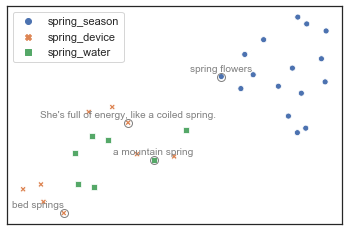

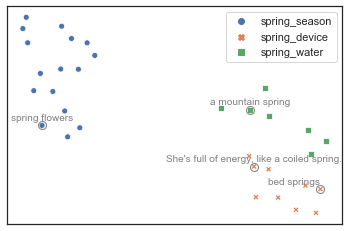

In [242]:
rd = 123
rep_large = get_reduce_df(large, examples, random_state=rd)
draw_sns_scatter(rep_large)
rep_largesem = get_reduce_df(largesem, examples, random_state=rd)
draw_sns_scatter(rep_largesem)